# 머신러닝 모델을 이용한 대한민국 코로나19 신규 확진자 예측

## 라이브러리 불러오기

In [ ]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

import numpy as np

## 데이터 불러오기

In [ ]:
# 코로나 19 한국 발생 현황
url = 'https://raw.githubusercontent.com/jooeungen/coronaboard_kr/master/kr_daily.csv'
df = pd.read_csv(url, error_bad_lines=False)
df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.





(764, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       764 non-null    int64  
 1   confirmed  764 non-null    int64  
 2   death      764 non-null    int64  
 3   released   764 non-null    int64  
 4   tested     764 non-null    int64  
 5   negative   764 non-null    int64  
 6   critical   583 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 41.9 KB


In [ ]:
df.head(5)

,date,confirmed,death,released,tested,negative,critical
0,20200121,1,0,0,1,0,NaN
1,20200122,1,0,0,1,0,NaN
2,20200123,1,0,0,1,0,NaN
3,20200124,2,0,0,2,0,NaN
4,20200125,2,0,0,2,0,NaN


In [ ]:
df.tail(5)

,date,confirmed,death,released,tested,negative,critical
759,20220218,1755787,7283,852368,17195152,14052403,385.0
760,20220219,1857995,7354,869695,17297360,14052403,408.0
761,20220220,1962822,7405,892289,17402187,14052403,439.0
762,20220221,2058184,7450,905128,17497549,14052403,480.0
763,20220222,2157734,7508,936891,17597099,14052403,480.0


In [ ]:
df['confirmed']

0            1
1            1
2            1
3            2
4            2
        ...   
759    1755787
760    1857995
761    1962822
762    2058184
763    2157734
Name: confirmed, Length: 764, dtype: int64

## 전처리

### 결측치 확인

In [ ]:
df.isnull()

,date,confirmed,death,released,tested,negative,critical
0,False,False,False,False,False,False,True
1,False,False,False,False,False,False,True
2,False,False,False,False,False,False,True
3,False,False,False,False,False,False,True
4,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...
759,False,False,False,False,False,False,False
760,False,False,False,False,False,False,False
761,False,False,False,False,False,False,False
762,False,False,False,False,False,False,False


In [ ]:
df.isnull().sum()

date           0
confirmed      0
death          0
released       0
tested         0
negative       0
critical     181
dtype: int64

### 데이터 변환

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       764 non-null    int64  
 1   confirmed  764 non-null    int64  
 2   death      764 non-null    int64  
 3   released   764 non-null    int64  
 4   tested     764 non-null    int64  
 5   negative   764 non-null    int64  
 6   critical   583 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 41.9 KB


In [ ]:
df=df.drop(['death', 'released', 'tested', 'negative', 'critical'], axis=1)
df.tail()

,date,confirmed
759,20220218,1755787
760,20220219,1857995
761,20220220,1962822
762,20220221,2058184
763,20220222,2157734


In [ ]:
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')
df['date']

0     2020-01-21
1     2020-01-22
2     2020-01-23
3     2020-01-24
4     2020-01-25
         ...    
759   2022-02-18
760   2022-02-19
761   2022-02-20
762   2022-02-21
763   2022-02-22
Name: date, Length: 764, dtype: datetime64[ns]

## 시각화

### Plot

In [ ]:
# 한국 코로나19 확진자 트렌드를 그래프로 만든다

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=df.confirmed,
        name='Confirmed in Korea'
    )
)

fig

## 학습

### Facebook Prophet

In [ ]:
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어준다
df_prophet = df.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

,ds,y
759,2022-02-18,1755787
760,2022-02-19,1857995
761,2022-02-20,1962822
762,2022-02-21,2058184
763,2022-02-22,2157734


In [ ]:
# Prophet에서 감안할 계절성을 선택해서 모델을 만든다
# changepoints을 추가하여 flexible 향상 (https://facebook.github.io/prophet/docs/trend_changepoints.html)

m = Prophet(
    changepoint_prior_scale=0.5, # trend를 더 flexible하게 만든다
    changepoint_range=0.95,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=7)

future.tail(7)

,ds
764,2022-02-23
765,2022-02-24
766,2022-02-25
767,2022-02-26
768,2022-02-27
769,2022-02-28
770,2022-03-01


## 예측

In [ ]:
forecast = m.predict(future)

# yhat : 예측값, yhat_lower : 오차를 고려한 예측 최소값, yhat_upper : 오차를 고려한 예측 최대값
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
764,2022-02-23,1.692977e+06,1.635630e+06,1.747878e+06
765,2022-02-24,1.722155e+06,1.660095e+06,1.778236e+06
766,2022-02-25,1.751568e+06,1.692968e+06,1.807482e+06
767,2022-02-26,1.780748e+06,1.723956e+06,1.837651e+06
768,2022-02-27,1.809910e+06,1.750943e+06,1.866887e+06
769,2022-02-28,1.838803e+06,1.783936e+06,1.897316e+06
770,2022-03-01,1.867765e+06,1.810679e+06,1.921430e+06


### Plot Prediction

In [ ]:
fig = plot_plotly(m, forecast)
py.iplot(fig)

### Plot changepoints

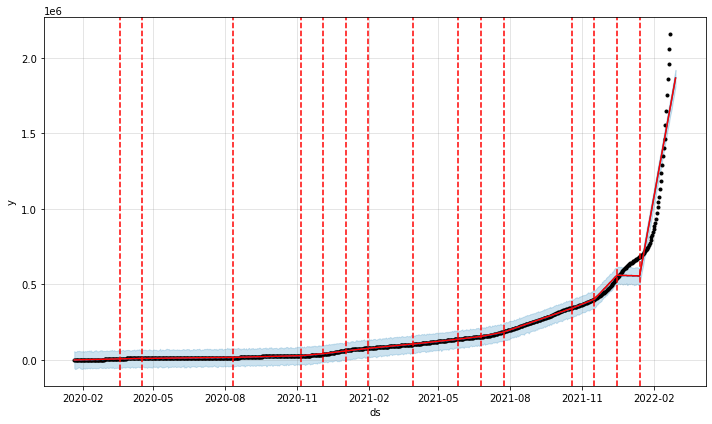

In [ ]:
# changepoint를 그래프에 반영
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)